# <center>**金融时间序列（一）**</center>

## **1. 输入库包**

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import statsmodels.api as sm
plt.style.use('seaborn')

## **2. 取出数据**

In [2]:
HS300_close=get_price(['000905.SH'], '20171125', '20190125', '1d', ['close'], True, None,is_panel=1)['close']
HS300_close.columns=['HS300_close']
HS300_close['return']=HS300_close['HS300_close'].pct_change()

## **3. 时间序列1（AR Model） **
时间序列的平稳性被分为严平稳和宽平稳。其中，严平稳需要两个时间序列在时间的平移变换下，它们的联合分布保持不变。而宽平稳只需要序列的均值、方差相同即可。
由于严平稳的实现较为困难，所以一般来说平稳时间序列指的是宽平稳。如果是非平稳时间序列，可以通过多次差分的方法处理为宽平稳序列。<br/>
下列，我们就对沪深300指数价格使用了2次和20次的差分。显而易见，差分次数越多越平稳。
### **3.1 价格差分**

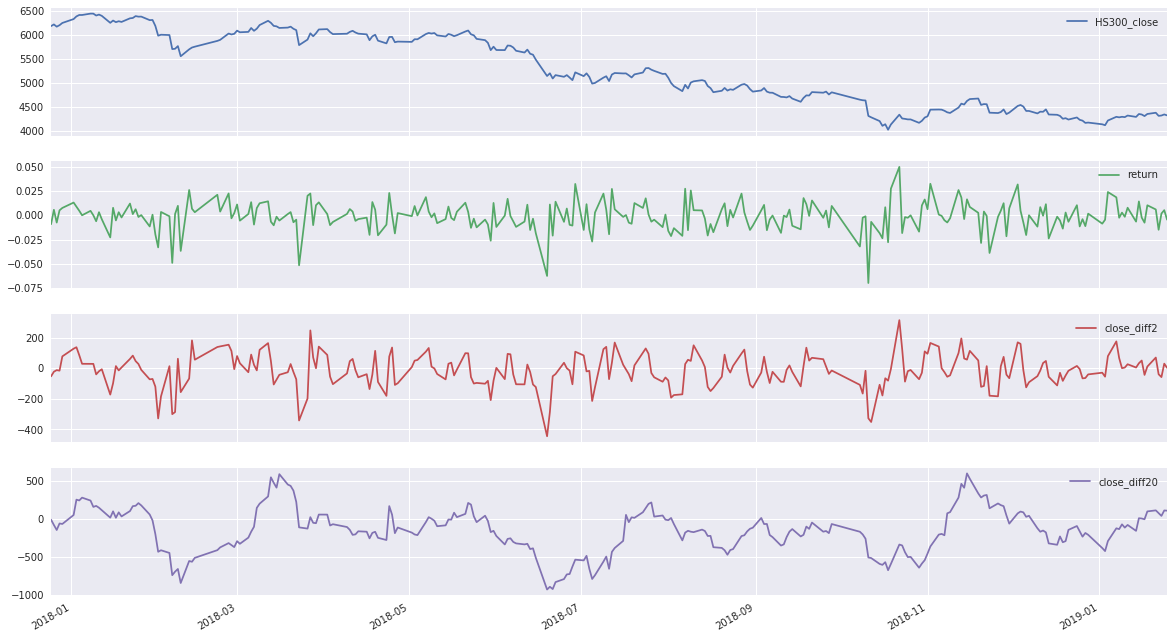

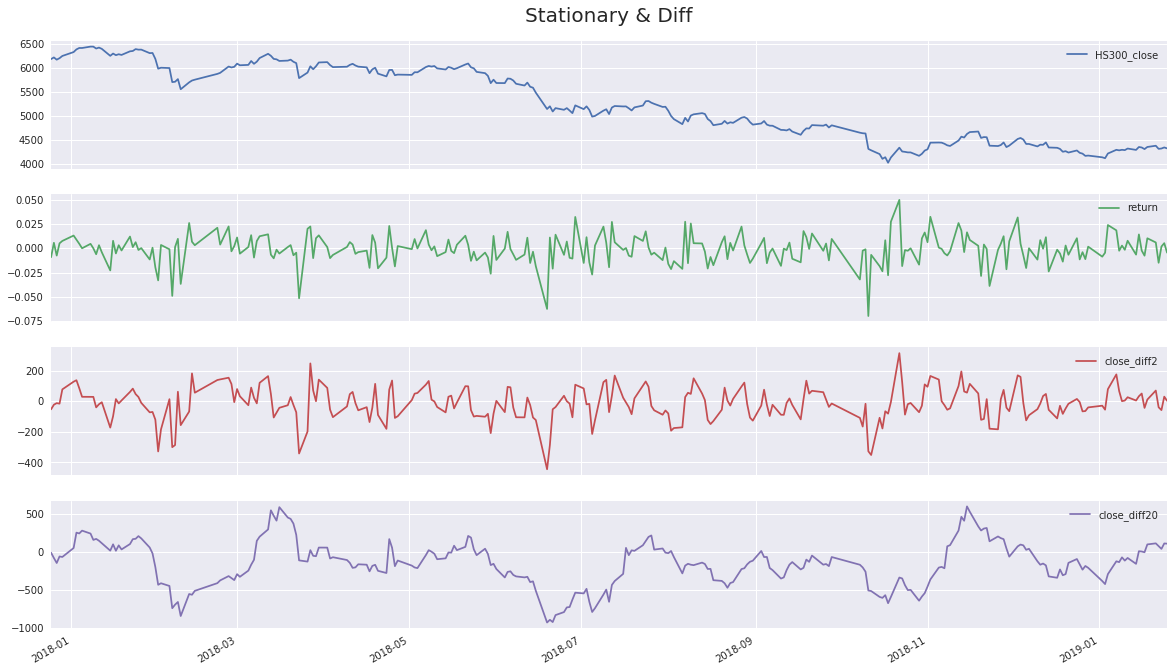

In [3]:
HS300_close['close_diff2']=HS300_close['HS300_close'].diff(2)
HS300_close['close_diff20']=HS300_close['HS300_close'].diff(20)
HS300_close.dropna(inplace=True)
HS300_close.plot(subplots=True,figsize=(20,12))
plt.title('Stationary & Diff',y=4.7,size=20)

### **3.2  ACF自相关函数**
自相关函数的含义是衡量序列数据和自己的相关程度，即x(t)和过去某个时间x(t−l)的相关性：
<center>![](http://u.thsi.cn/imgsrc/sns/dc741db4f20969ed0e3d6d4296e6322d_450_86.png)</center><br/>
该假设检验统计量服从自由度为m的卡方分布。<br/>
原假设为所有自相关系数为0，取显著水平为0.05，若所有p值均小于0.05则拒绝原假设，认为该序列存在序列相关性。<br/>
以下是该假设检验统计量：<br/>
<center>![](http://u.thsi.cn/imgsrc/sns/08a205bcb6a5593701071ab07002fd25_314_87.png)</center>

In [4]:
closeprice=HS300_close['HS300_close']
ACF,Q_test,P_value= sm.tsa.acf(closeprice, nlags=10, qstat = True)
data_show=np.c_[range(1,11),ACF[1:],Q_test,P_value]
data_df=pd.DataFrame(data_show,columns=['Lag','ACF','Q_test','P_value'])
data_df.set_index('Lag',inplace=True)
data_df.head(8)

,ACF,Q_test,P_value
Lag,,,
1.0,0.988893,263.068428,3.678637e-59
2.0,0.978027,521.362501,6.131565e-114
3.0,0.967327,774.996387,1.145044e-167
4.0,0.954426,1022.852307,3.981759e-220
5.0,0.942327,1265.390107,2.010084e-271
6.0,0.929604,1502.330397,0.000000e+00
7.0,0.917226,1733.893361,0.000000e+00
8.0,0.904332,1959.864313,0.000000e+00


In [5]:
returndata=HS300_close['return']
ACF,Q_test,P_value= sm.tsa.acf(returndata, nlags=10, qstat = True)
data_show=np.c_[range(1,11),ACF[1:],Q_test,P_value]
data_df=pd.DataFrame(data_show,columns=['Lag','ACF','Q_test','P_value'])
data_df.set_index('Lag',inplace=True)
data_df.head(8)

,ACF,Q_test,P_value
Lag,,,
1.0,-0.039574,0.421299,0.516290
2.0,-0.002226,0.422637,0.809516
3.0,0.158975,7.273077,0.063685
4.0,-0.084468,9.214393,0.055958
5.0,-0.013899,9.267154,0.098871
6.0,-0.126374,13.645968,0.033851
7.0,0.045564,14.217403,0.047447
8.0,-0.080795,16.021095,0.042079


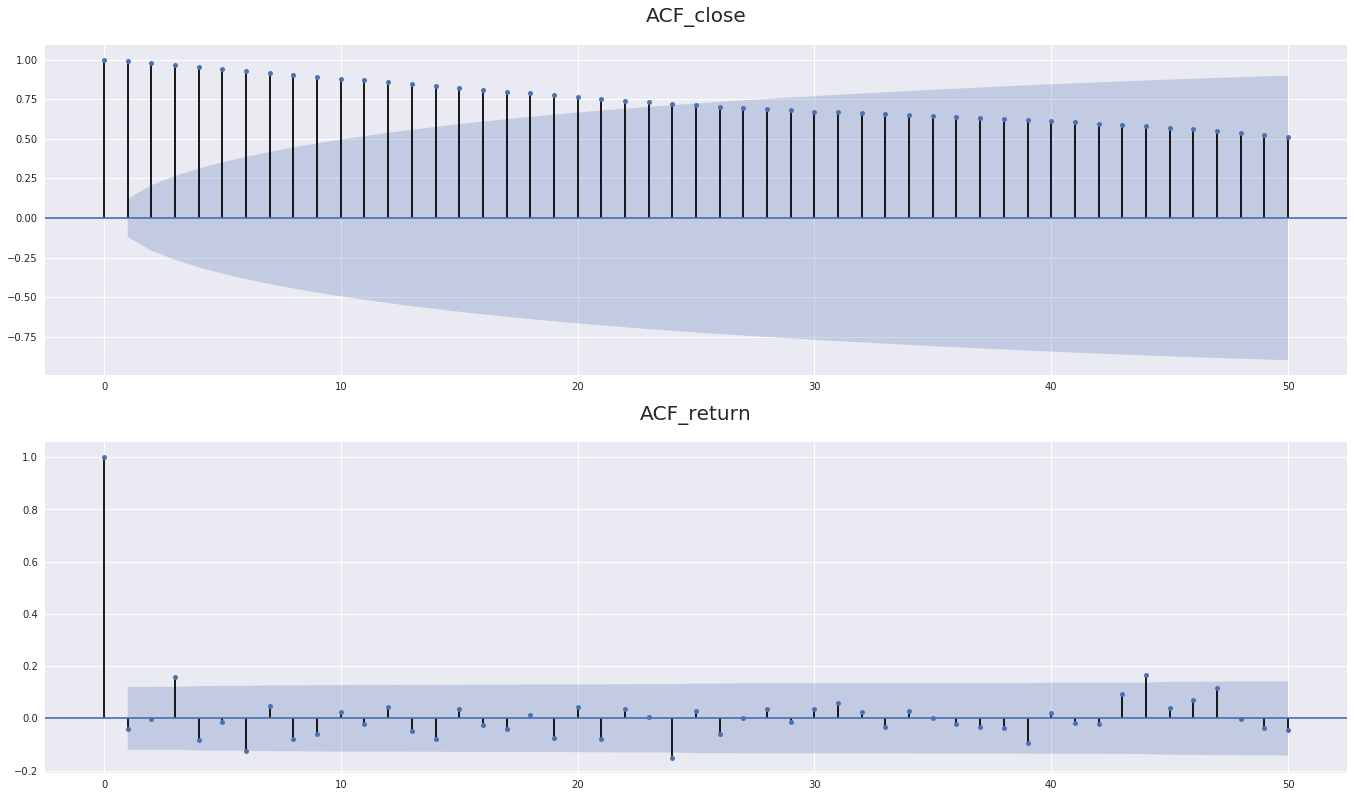

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(20,12))        
ax1=fig.add_subplot(211)
plot_acf(closeprice,lags=50,ax=ax1)
plt.title('ACF_close',y=1.05,size=20)
plt.tight_layout(5)                     #设置子图间距
ax2=fig.add_subplot(212)
plot_acf(returndata,lags=50,ax=ax2)
plt.title('ACF_return',y=1.05,size=20)
plt.show()


### ** 3.3 AR模型**
AR模型公式：<br/>
<center>![](http://u.thsi.cn/imgsrc/sns/a6c6dcc02ac3f612ba0fce2f644ab7cb_407_57.png)</center><br/>
AR模型的3个限制如下：<br/><br/>
<center>![](http://u.thsi.cn/imgsrc/sns/bb349f57d750ddf9b5bed72b39bd8209_523_102.png)</center><br/>
μ是{rt}序列的均值,μ的值为：<br/>
<center>![](http://u.thsi.cn/imgsrc/sns/8b76c95e2d63f6cc89601ba001ae2819_317_73.png)<center><br/>

**1. 使用5阶AR模型**

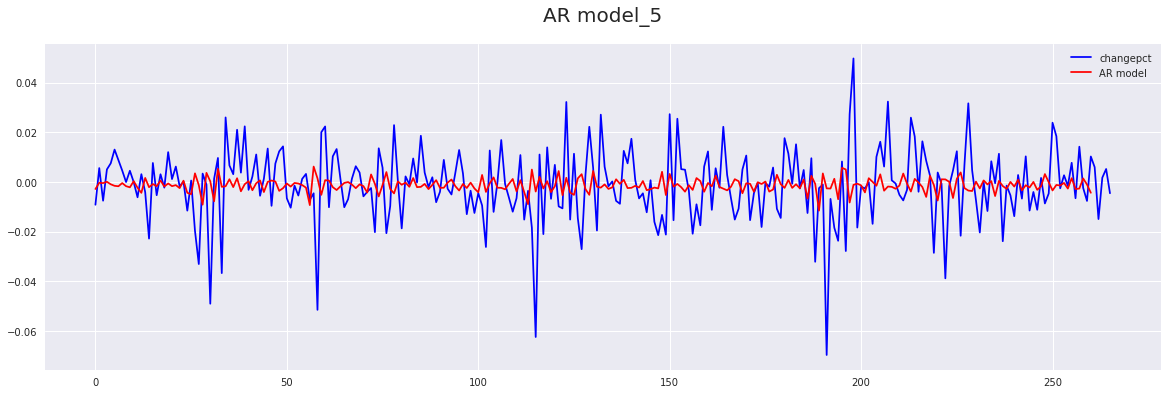

In [7]:
changedata = returndata  # 载入收益率序列
changedata = np.array(changedata, dtype=np.float)
model = sm.tsa.AR(changedata)
results_AR = model.fit(5)           #阶数
plt.figure(figsize=(20,6))
plt.plot(changedata, 'b', label = 'changepct')
plt.plot(results_AR.fittedvalues, 'r', label = 'AR model')
plt.title('AR model_5',y=1.05,size=20)
plt.legend()

In [8]:
len(results_AR.roots)   #打印阶数

5

**2. 使用100阶AR模型**

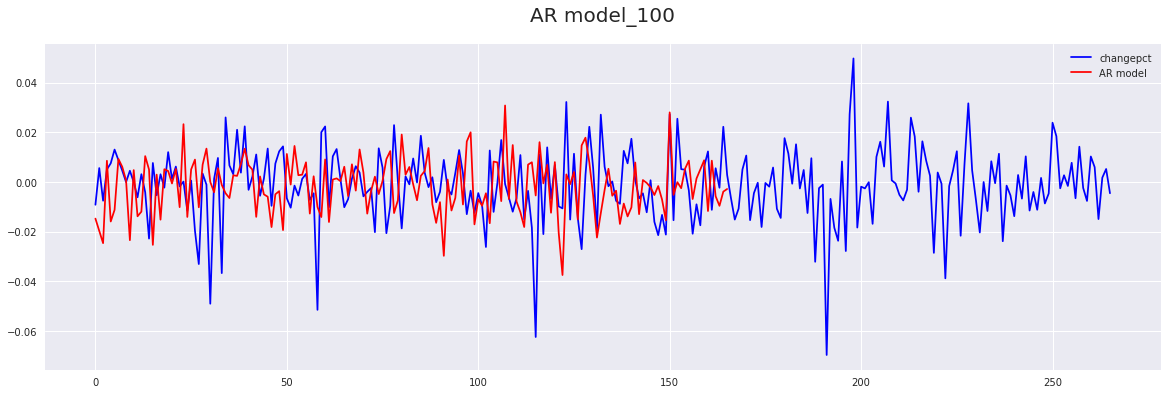

In [9]:
changedata = returndata  # 载入收益率序列
changedata = np.array(changedata, dtype=np.float)
model = sm.tsa.AR(changedata)
results_AR = model.fit(100)           #阶数
plt.figure(figsize=(20,6))
plt.plot(changedata, 'b', label = 'changepct')
plt.plot(results_AR.fittedvalues, 'r', label = 'AR model')
plt.title('AR model_100',y=1.05,size=20)
plt.legend()

** 3. 检验残差：**
残差是不应该有自回归的，把残差拿出来检验下，在 2 附近，意味着没有自回归。

In [10]:
sm.stats.durbin_watson(results_AR.resid) # 把残差拿出来检验下

1.993642286632106

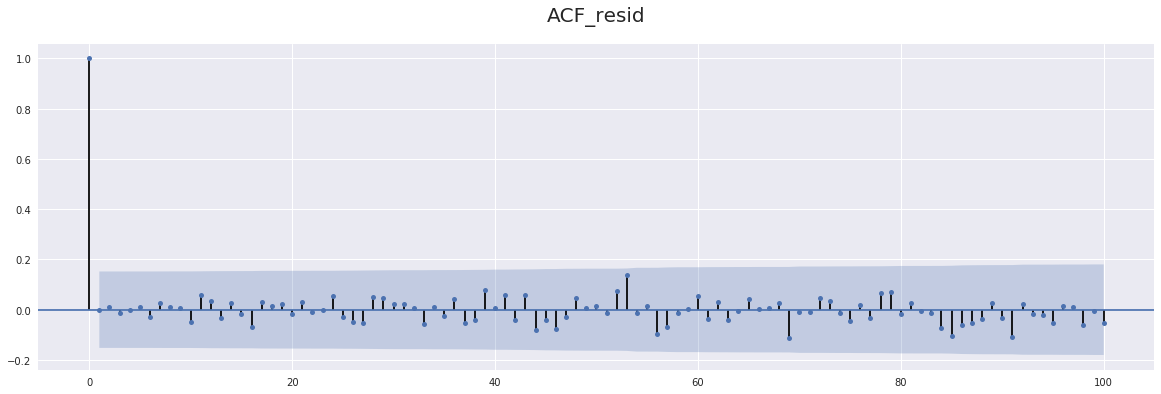

In [11]:
fig = plt.figure(figsize=(20,6))        
ax=fig.add_subplot(111)
plot_acf(results_AR.resid,lags=100,ax=ax)
plt.title('ACF_resid',y=1.05,size=20)
plt.show()

### **3.4 PACF偏相关函数**
以上我们讲解了AR模型，对于线性回归模型的阶数，一般随着阶数的升高，会提高模型的拟合度，但是过高的阶数会造成模型过于复杂。以下我们会介绍两种确定AR模型阶数的方法：偏相关函数（pACF）和信息准则函数（AIC、BIC、HQIC）<br/>
首先，我们看一个一阶AR模型：<br/>
<center>![](http://u.thsi.cn/imgsrc/sns/4cd8c08b6abbb3e5f5b6f76b4c5cc06a_210_108.png)</center><br/>
我们很清楚地看到，在AR(1)模型中，即使y(t-2)没有直接出现在模型中，但是y(t)和y(t-2)之间也相关，
而PACF偏相关系数将会排除了其他变量的影响之后两个变量之间的相关系数，所以对于AR模型，当超过某个阶数时，偏自相关函数应逐渐趋近于0。

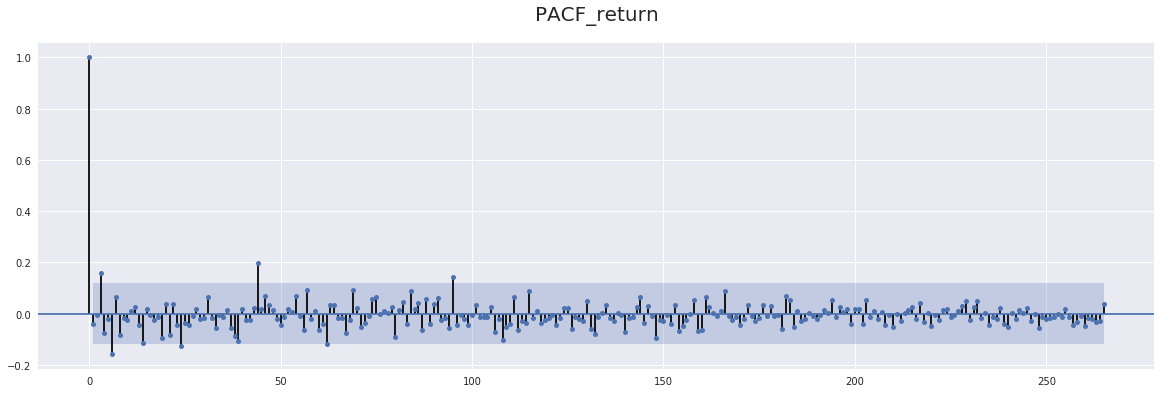

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(111)
fig = plot_pacf(changedata,ax=ax1)
plt.title('PACF_return',y=1.05,size=20)
plt.show()

### **3.5 AIC BIC HQIC**

- 通常情况下，当模型复杂度提高（k增大）时，似然函数L也会增大，从而使AIC变小，但是k过大时，似然函数增速减缓，导致AIC增大，模型过于复杂容易造成过拟合现象。目标是选取AIC最小的模型，AIC不仅要提高模型拟合度（极大似然），而且引入了惩罚项，使模型参数尽可能少，有助于降低过拟合的可能性。<br/><br/>
- BIC贝叶斯信息准则与AIC相似，用于模型选择，1978年由Schwarz提出。训练模型时，增加参数数量，也就是增加模型复杂度，会增大似然函数，但是也会导致过拟合现象，针对该问题，AIC和BIC均引入了与模型参数个数相关的惩罚项，BIC的惩罚项比AIC的大，考虑了样本数量，样本数量过多时，可有效防止模型精度过高造成的模型复杂度过高。<br/><br/>
- HQIC与之前两种方法类似<br/><br/>

<center>![](http://u.thsi.cn/imgsrc/sns/9fded373eedfa692806f0f2501df0aa6_332_115.png)</center><br/>

In [22]:
aicList = []
bicList = []
hqicList = []
for i in range(1,10):  #从1阶到9阶
    order = (i,0)  # 使用ARMA模型，其中MA阶数为0，只考虑了AR阶数。
    print(i)
    chgdataModel = sm.tsa.ARMA(changedata,order).fit()
    aicList.append(chgdataModel.aic)
    bicList.append(chgdataModel.bic)
    hqicList.append(chgdataModel.hqic)

1
2
3
4
5
6
7
8
9


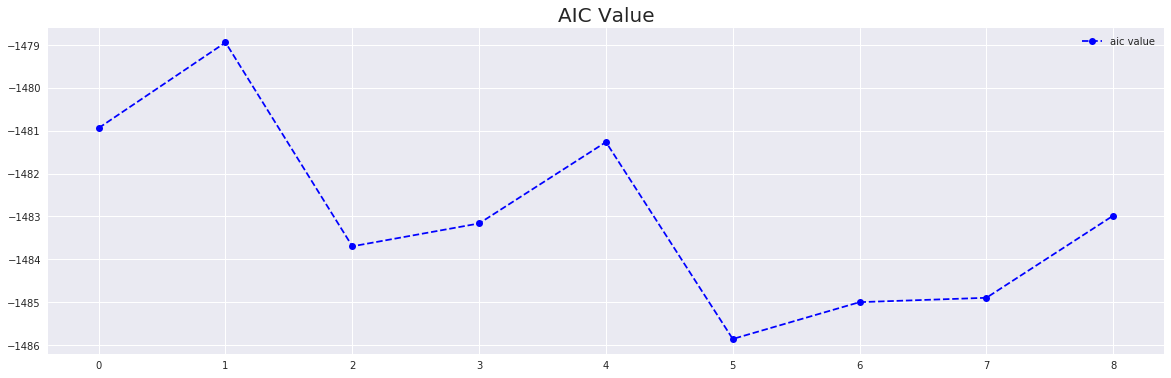

In [32]:
plt.figure(figsize=(20,6))
plt.plot(aicList,'bo--',label='aic value')
plt.title('AIC Value',size=20)
plt.legend(loc=0)

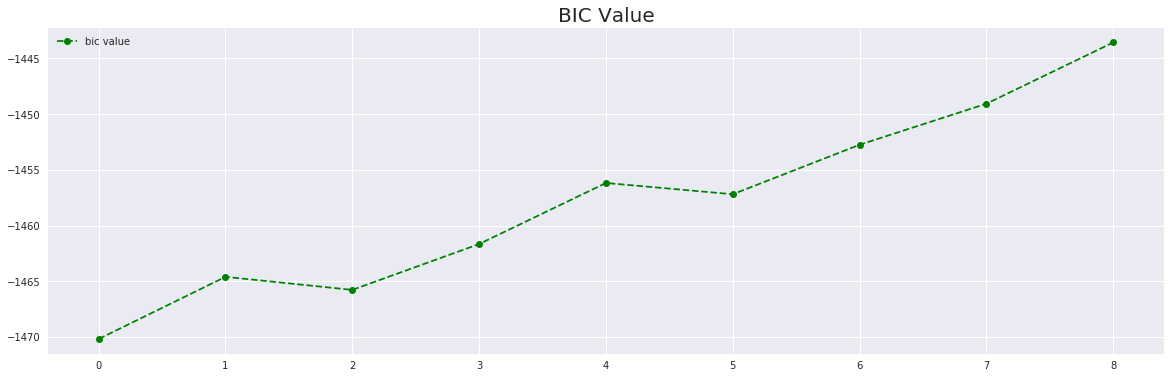

In [33]:
plt.figure(figsize=(20,6))
plt.plot(bicList,'go--',label='bic value')
plt.title('BIC Value',size=20)
plt.legend(loc=0)

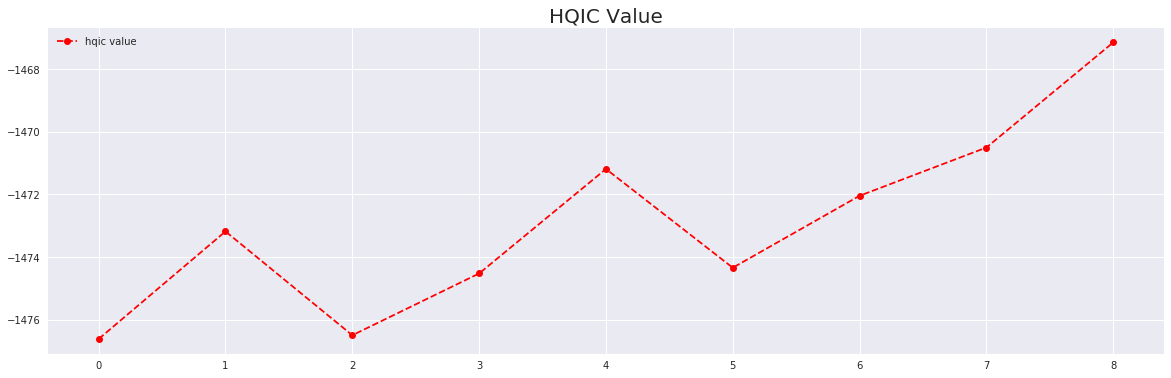

In [35]:
plt.figure(figsize=(20,6))
plt.plot(hqicList,'ro--',label='hqic value')
plt.title('HQIC Value',size=20)
plt.legend(loc=0)

### **3.6 AR模型的有效性检验**
一个好的拟合模型应该能够提取观测值序列中几乎所有的样本相关信息，即残差序列应该为白噪声序列。因此，模型的有效性检验即为残差序列的白噪声检验。如果残差序列是白噪声，那么理论赏其延迟任意阶的自相关系数为 0，考虑数据的偏差，那么绝大多数应该在 0 附近的范围内，通常在 95% 的置信水平（2倍标准差）以内。

In [36]:
changedata = returndata  # 载入收益率序列
changedata = np.array(changedata, dtype=np.float)
model = sm.tsa.AR(changedata)
results_AR_5 = model.fit(5)  

delta=results_AR_5.fittedvalues-changedata[len(results_AR_5.roots):]
ACF,Q_value,P_value=sm.tsa.acf(delta,nlags=10,qstat=True)
data_show=np.c_[range(1,11),ACF[1:],Q_test,P_value]
data_df=pd.DataFrame(data_show,columns=['Lag','ACF','Q_test','P_value'])
data_df.set_index('Lag',inplace=True)
data_df.head()

,ACF,Q_test,P_value
Lag,,,
1.0,-0.005176,0.421299,0.932973
2.0,-0.013567,0.422637,0.972458
3.0,0.027973,7.273077,0.966643
4.0,-0.018705,9.214393,0.985807
5.0,0.006151,9.267154,0.996174


### **3.7 AR模型的Adjusted Rsquare值:** <br/>
<center>![](http://u.thsi.cn/imgsrc/sns/9276329567ce1df8082f833063449efd_215_105.png)</center>

In [37]:
adjR = 1 - delta.var()/changedata[len(results_AR_5.roots):].var()
print(adjR)

0.032478175450361024


## 4. 时间序列2 （MA Model）
由于MA模型是白噪声序列（均值方差恒定）的有限线性组合，因此MA模型具有弱平稳性。
<center>![](http://u.thsi.cn/imgsrc/sns/ec8fb0aa1283d8166461e46e4c41a8cd_390_60.png)</center><br/>
在此之前，我们通过计算偏自相关函数（pACF）等方法可以粗略确定AR模型的阶数。但对于MA模型，由于它是白噪声序列，所以我们只需要需要采用自相关函数（ACF）进行定阶即可。


### ** 4.1 确定阶数**

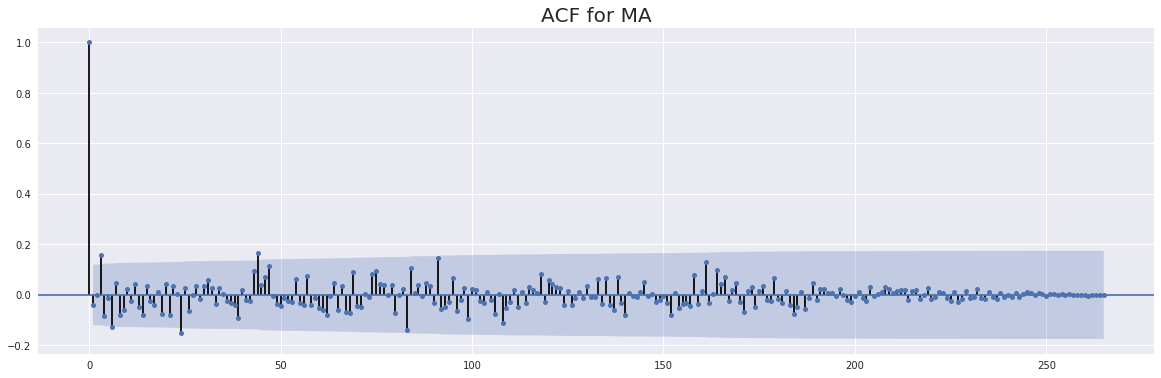

In [38]:
fig=plt.figure(figsize=(20,6))
ax=fig.add_subplot(111)
fig=plot_acf(changedata,ax=ax)
plt.title('ACF for MA',size=20)
plt.show()

In [39]:
aicList2 = []
for i in range(1,11):  #从1阶到10阶
    order = (0,i)  # 使用ARMA模型，其中AR阶数为0，只考虑了MA阶数。
    print(i)
    chgdataModel = sm.tsa.ARMA(changedata,order).fit()
    aicList2.append(chgdataModel.aic)

1
2
3
4
5
6
7
8
9
10


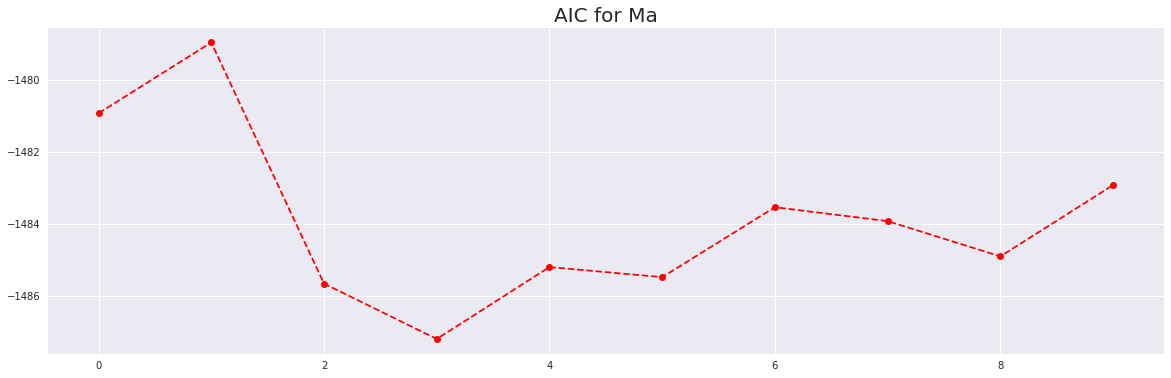

In [41]:
plt.figure(figsize=(20,6))
plt.plot(aicList2,'ro--',label='aic value')
plt.title('AIC for Ma',size=20)
plt.show()

### **4.2 利用AIC得出的3阶**

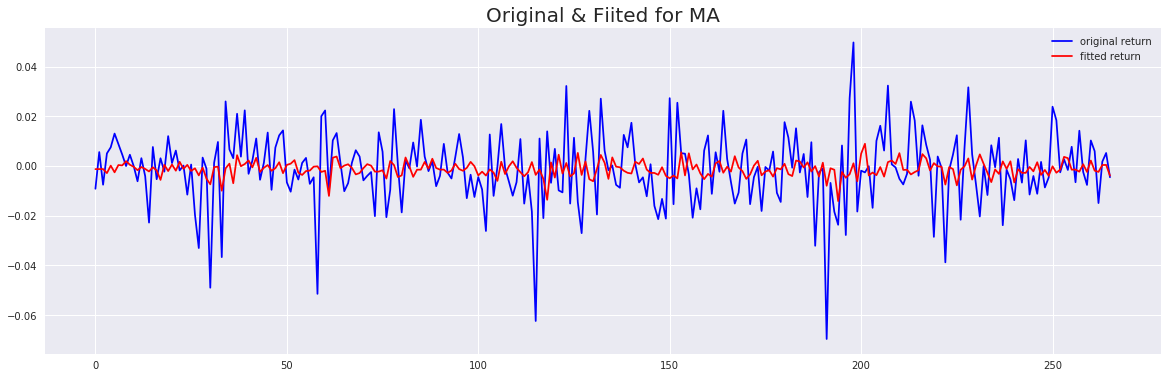

In [47]:
MA_data=sm.tsa.ARMA(changedata,(0,3)).fit()
plt.figure(figsize=(20,6))
plt.plot(changedata,'b',label='original return')
plt.plot(MA_data.fittedvalues,'r',label='fitted return')
plt.title('Original & Fiited for MA',size=20)
plt.legend()

In [13]:
n=int(len(changedata)*9/10)
n

239

In [85]:
train_data=changedata[:n]
test_data=changedata[n:]
clf=sm.tsa.ARMA(train_data,(0,3)).fit()
predict_data=clf.predict(n,int(len(changedata))-1,dynamic=True)
combined_data=np.c_[test_data,predict_data]
compare_data=pd.DataFrame(combined_data,columns=['original_data','predict_data'])
compare_data.head()

,original_data,predict_data
0,-0.005399,0.001980
1,-0.013783,-0.006899
2,0.002793,-0.001445
3,-0.006718,-0.001431
4,0.010299,-0.001431


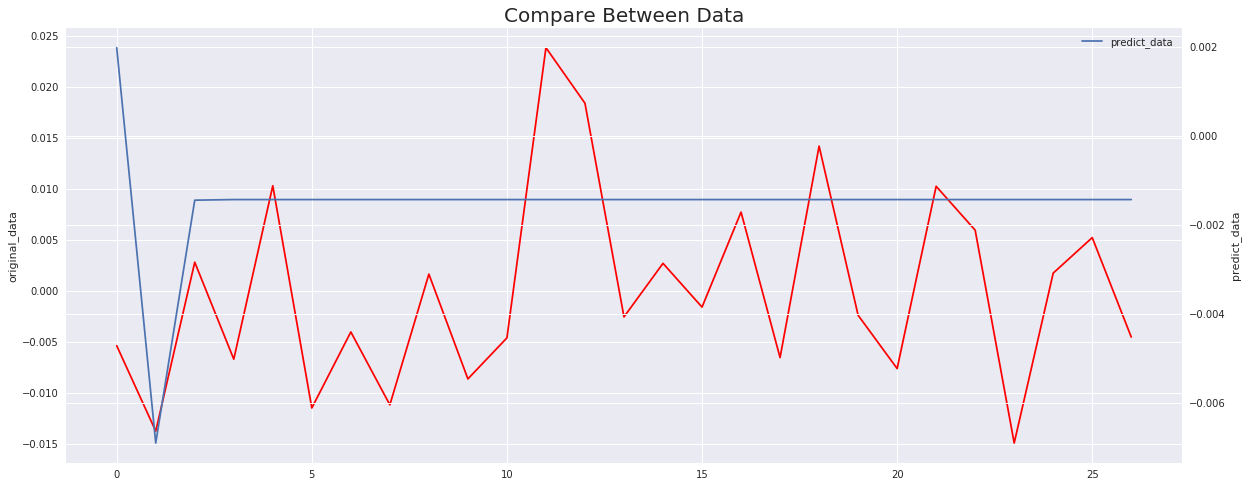

In [86]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(compare_data['original_data'],color='r')
ax.set_ylabel('original_data')
ax=ax.twinx()
ax.plot(compare_data['predict_data'])
ax.set_ylabel('predict_data')
ax.set_title('Compare Between Data',size=20)
ax.legend()
plt.show()

### **4.3 利用ACF得出的阶数**
其实超过置信区间的是43阶才行，但这会导致速度太慢，且算力有限。我们只展示15阶，用以显示与3阶的区别。

In [14]:
train_data2=changedata[:n]
test_data2=changedata[n:]
clf2=sm.tsa.ARMA(train_data2,(0,15)).fit()
predict_data2=clf2.predict(n,int(len(changedata))-1,dynamic=True)
combined_data2=np.c_[test_data2,predict_data2]
compare_data2=pd.DataFrame(combined_data2,columns=['original_data','predict_data'])
compare_data2.head()

,original_data,predict_data
0,-0.005399,0.004396
1,-0.013783,-0.007076
2,0.002793,0.002488
3,-0.006718,-0.009059
4,0.010299,-0.001734


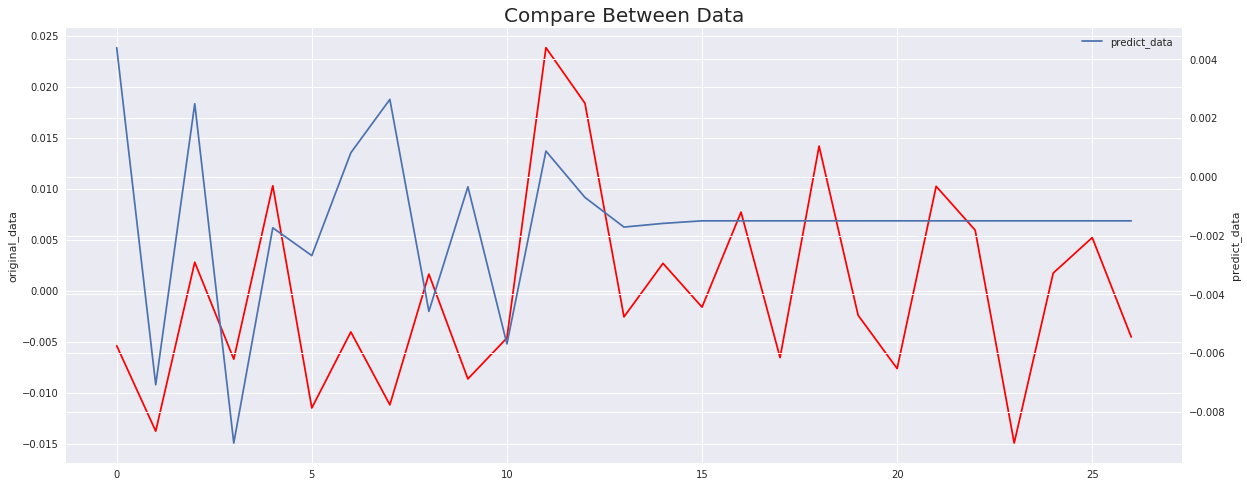

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(compare_data2['original_data'],color='r')
ax.set_ylabel('original_data')
ax=ax.twinx()
ax.plot(compare_data2['predict_data'])
ax.set_ylabel('predict_data')
ax.set_title('Compare Between Data',size=20)
ax.legend()
plt.show()

### **4.4 MA模型的Adjusted Rsquare值**

In [16]:
delta_ma=clf2.fittedvalues-train_data2
adjR_MA=1-delta_ma.var()/train_data2.var()
adjR_MA

0.10082118131965845

## **5. 时间序列3（ARIMA模型）**
我们之前主要探讨了AR model和MA model,但它们的缺点显而易见，如果无限增加阶数，势必会很好的拟合图线，但非常容易尝试过拟合的现象。然而使用AIC，BIC等方法确定阶数，也很难达到预期效果。<br/>
故我们继而展开对于ARIMA模型的研究，我们知道之前的ARMA模型研究的对象为平稳时间序列。如果序列是非平稳的，需要通过差分的方法将其变为平稳时间序列，也我们接下来要描述的ARIMA模型。ARIMA模型需要确定三个阶数，AR模型的阶数p，差分的阶数d和MA模型的阶数q，通常写作ARIMA(p,d,q)。

### ** 5.1 ADF检验**
当p值小于0.05时，ADF test可以判断序列是平稳的。

In [2]:
HS300_close=get_price(['000905.SH'], '20171125', '20190125', '1d', ['close'], True, None,is_panel=1)['close']
HS300_close.columns=['HS300_close']
HS300_close['return']=HS300_close['HS300_close'].pct_change()
HS300_close['close_diff1']=HS300_close['HS300_close'].diff(1)
HS300_close['close_diff2']=HS300_close['HS300_close'].diff(2)
HS300_close['close_diff3']=HS300_close['HS300_close'].diff(3)
HS300_close.dropna(inplace=True)

close_original=np.array(HS300_close['HS300_close'])
close_diff1=np.array(HS300_close['close_diff1'])
close_diff2=np.array(HS300_close['close_diff2'])
close_diff3=np.array(HS300_close['close_diff3'])

adftest = sm.tsa.stattools.adfuller(close_original)
adftest_diff1=sm.tsa.stattools.adfuller(close_diff1)
adftest_diff2=sm.tsa.stattools.adfuller(close_diff2)
adftest_diff3=sm.tsa.stattools.adfuller(close_diff3)

adftest_df=pd.DataFrame(index=["p-value"],columns=["original", "diff1", "diff2","diff3"])
adftest_df.loc["p-value"]["original", "diff1", "diff2","diff3"] = adftest[1], adftest_diff1[1], adftest_diff2[1],adftest_diff3[1]
adftest_df

,original,diff1,diff2,diff3
p-value,0.845037,2.47672e-11,8.88978e-06,8.91274e-05


### **5.2 确定阶数**

In [24]:
sm.tsa.arma_order_select_ic(close_diff3,max_ar=6,max_ma=5,ic='aic')['aic_min_order']

(1, 5)

In [21]:
n=int(len(close_diff2)*9/10)
n

254

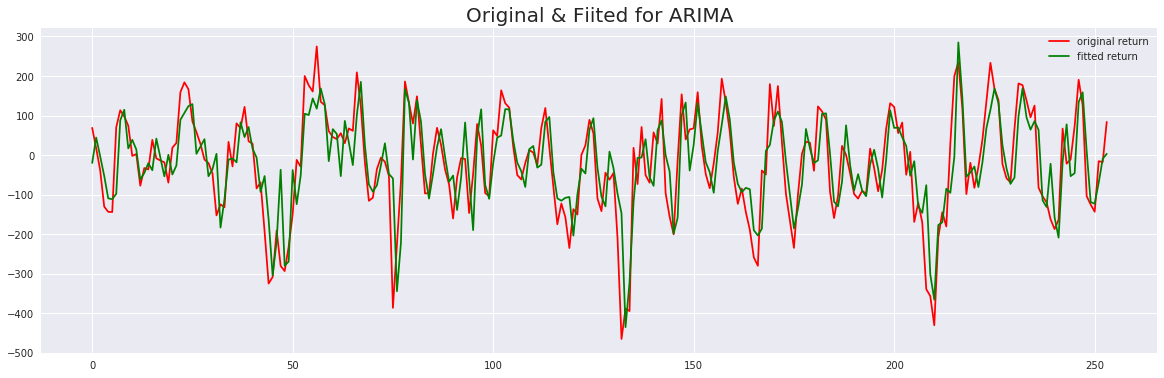

In [25]:
train_data=close_diff3[:n]
test_data=close_diff3[n:]

ARIMA_data=sm.tsa.ARMA(train_data,(1,5)).fit()
plt.figure(figsize=(20,6))
plt.plot(train_data,'r',label='original return')
plt.plot(ARIMA_data.fittedvalues,'g',label='fitted return')
plt.title('Original & Fiited for ARIMA',size=20)
plt.legend()

In [27]:
clf3=sm.tsa.ARMA(train_data,(1,5)).fit()
predict_data3=clf3.predict(n,int(len(close_diff3))-1,dynamic=True)
combined_data3=np.c_[test_data,predict_data3]
compare_data3=pd.DataFrame(combined_data3,columns=['original_data','predict_data'])
compare_data3.head()

,original_data,predict_data
0,-58.4677,67.053829
1,-62.6775,57.413970
2,-135.8897,8.162828
3,-89.2034,-16.490853
4,-70.8851,-2.693174


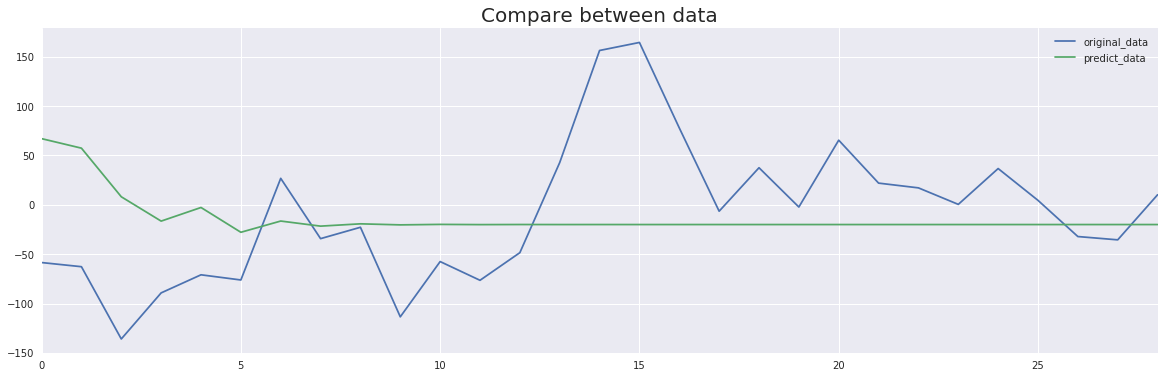

In [31]:
compare_data3.plot(figsize=(20,6))
plt.title('Compare between data',size=20)

In [32]:
delta_ARIMA=clf3.fittedvalues-train_data
adjR_ARIMA=1-delta_ARIMA.var()/train_data.var()
adjR_ARIMA

0.6514003653433447